In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to MIMIC-III dataset
con = create_connection()

# Heart Rate in Adult Patients

In [4]:
query = \
"""
WITH agetbl AS
(
  SELECT ad.subject_id
  FROM admissions ad
  INNER JOIN patients p
  ON ad.subject_id = p.subject_id
  WHERE
  -- filter to only adults
  EXTRACT(YEAR FROM age(ad.admittime, p.dob)) > 15
  -- group by subject_id to ensure there is only 1 subject_id per row
  group by ad.subject_id
)
, hr as
(
  SELECT width_bucket(valuenum, 0, 300, 301) AS bucket
  FROM chartevents ce
  INNER JOIN agetbl
  ON ce.subject_id = agetbl.subject_id
  WHERE itemid in (211,220045)
)
SELECT bucket as heart_rate, count(*)
FROM hr
GROUP BY bucket
ORDER BY bucket;
"""

heart_rates_adults = query_data(query, con)
print(heart_rates_adults.head())

   heart_rate  count
0         0.0      2
1         1.0   2487
2         2.0      9
3         3.0     11
4         4.0     12


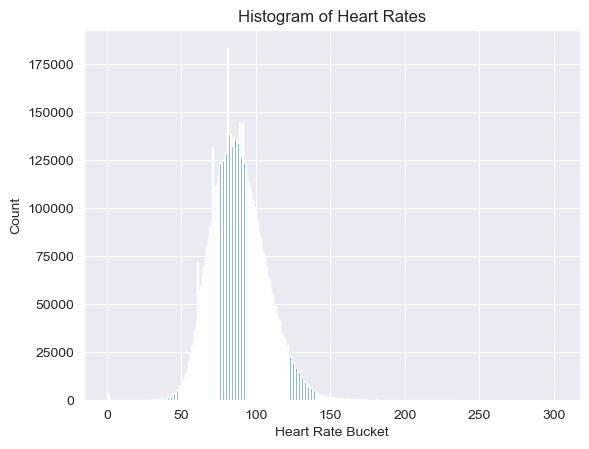

In [5]:
plt.bar(heart_rates_adults['heart_rate'], heart_rates_adults['count'])
plt.title('Histogram of Heart Rates')
plt.xlabel('Heart Rate Bucket')
plt.ylabel('Count')
plt.show()

# Temperature in Adult Patients

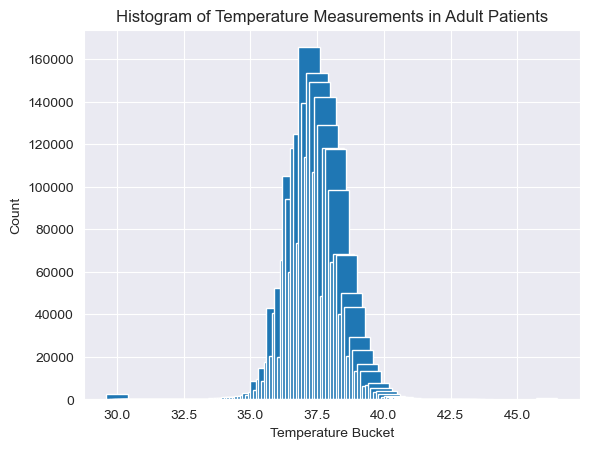

In [6]:
query  = \
"""
WITH agetbl AS
(
  SELECT ad.subject_id, ad.hadm_id
  FROM admissions ad
  INNER JOIN patients p
  ON ad.subject_id = p.subject_id
  WHERE
  -- filter to only adults
  EXTRACT(YEAR FROM age(ad.admittime, p.dob)) > 15
  -- group by subject_id to ensure there is only 1 subject_id per row
  group by ad.subject_id, ad.hadm_id
)
, temp as
(
  SELECT width_bucket(
      CASE
        WHEN itemid IN (223762, 676, 677) THEN valuenum -- celsius
        WHEN itemid IN (223761, 678, 679) THEN (valuenum - 32) * 5 / 9 --fahrenheit
      END
    , 30, 45, 160) AS bucket
  FROM chartevents ce
  INNER JOIN agetbl
  ON ce.hadm_id = agetbl.hadm_id
  WHERE itemid IN
  (
      676 -- Temperature C
    , 677 -- Temperature C (calc)
    , 678 -- Temperature F
    , 679 -- Temperature F (calc)
    , 223761 -- Temperature Fahrenheit
    , 223762 -- Temperature Celsius
  )
)
SELECT round((cast(bucket as numeric)/10) + 30,2) as temperature, count(*)
FROM temp
GROUP BY bucket
ORDER BY bucket;
"""
temperature_adults = query_data(query, con)
plt.bar(temperature_adults['temperature'], temperature_adults['count'])
plt.title('Histogram of Temperature Measurements in Adult Patients')
plt.xlabel('Temperature Bucket')
plt.ylabel('Count')
plt.show()

# Vital Signs for First Day of Admission

In [7]:
script = query_sql_file('../sql_scripts/vital_signs/vital_signs_first_day.sql', con)
df = query_data(script[0], con)
print(df.head())

   subject_id  hadm_id  icustay_id  heartrate_min  heartrate_max  \
0           2   163353      243653          140.0          140.0   
1           3   145834      211552           75.0          168.0   
2           4   185777      294638           74.0          111.0   
3           6   107064      228232           76.0          100.0   
4           7   118037      236754          115.0          121.0   

   heartrate_mean  sysbp_min  sysbp_max  sysbp_mean  diasbp_min  ...  \
0      140.000000        NaN        NaN         NaN         NaN  ...   
1      111.785714       64.0      217.0  102.960000        28.0  ...   
2       89.217391       97.0      139.0  118.000000        55.0  ...   
3       84.160000      127.0      187.0  153.647059        40.0  ...   
4      118.000000        NaN        NaN         NaN         NaN  ...   

   resprate_mean  tempc_min  tempc_max  tempc_mean  spo2_min  spo2_max  \
0            NaN        NaN        NaN         NaN       NaN       NaN   
1      17.

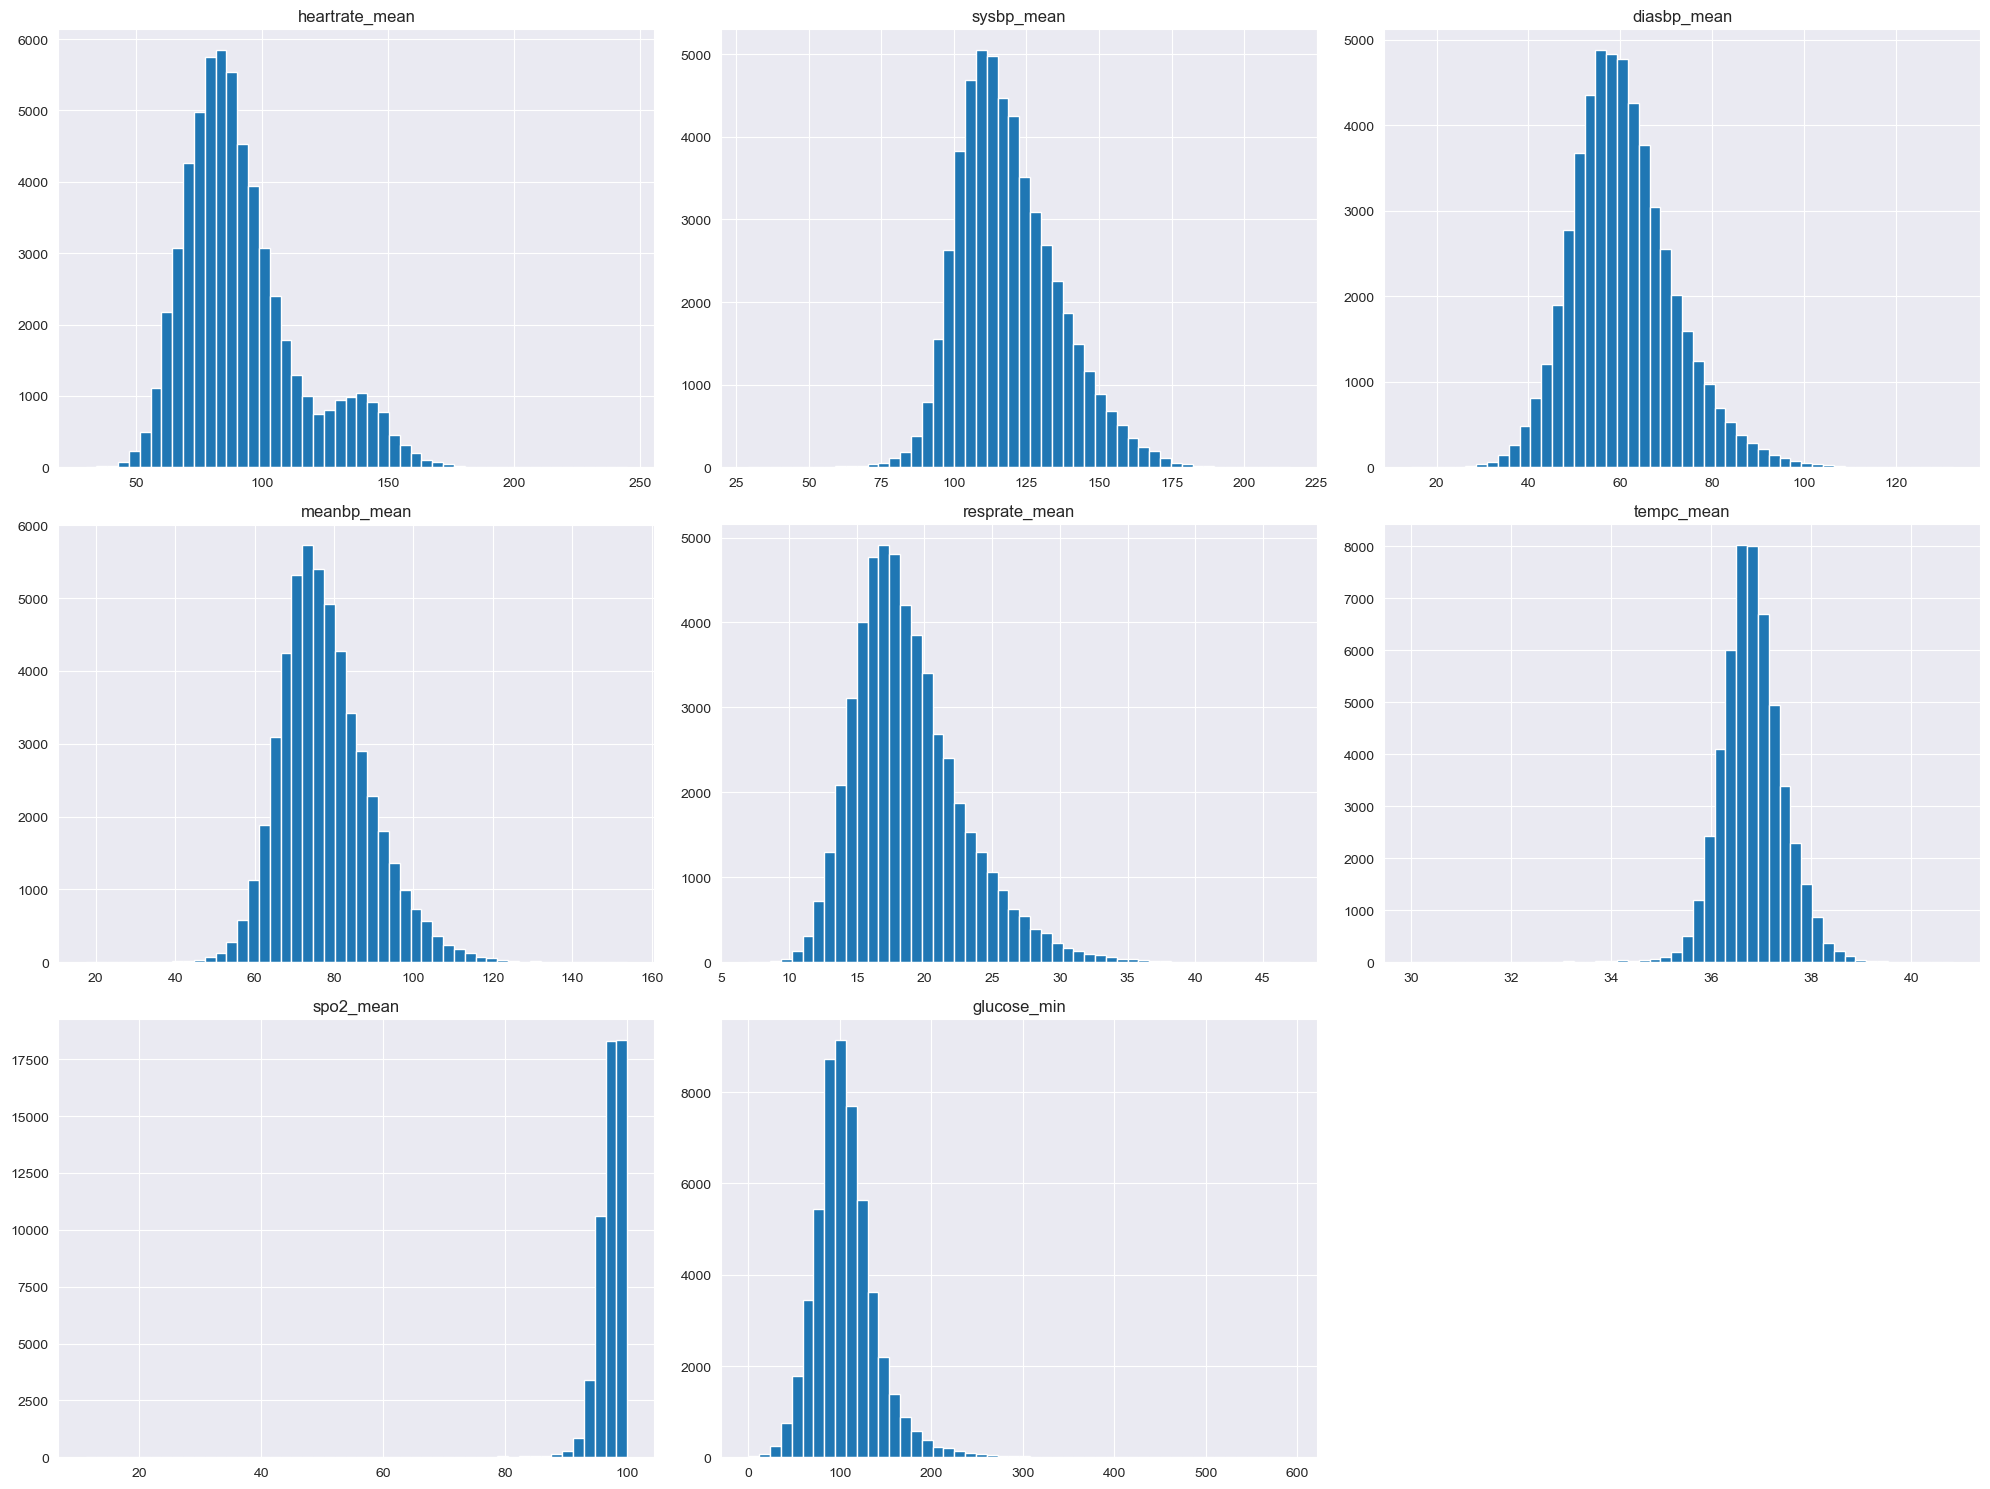

In [8]:
# Histograms
df[['heartrate_mean',
    'sysbp_mean',
    'diasbp_mean',
    'meanbp_mean',
    'resprate_mean',
    'tempc_mean',
    'spo2_mean',
    'glucose_min']].hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

In [9]:
admissions = pd.read_csv('../dataset/patient_stay_data.csv')
print(admissions.head())

   subject_id  hadm_id admission_type         admission_location ethnicity  \
0          22   165315      EMERGENCY       EMERGENCY ROOM ADMIT     WHITE   
1          23   152223       ELECTIVE  PHYS REFERRAL/NORMAL DELI     WHITE   
2          23   124321      EMERGENCY  TRANSFER FROM HOSP/EXTRAM     WHITE   
3          24   161859      EMERGENCY  TRANSFER FROM HOSP/EXTRAM     WHITE   
4          25   129635      EMERGENCY       EMERGENCY ROOM ADMIT     WHITE   

                                           diagnosis  hospital_expire_flag  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

  gender  expire_flag  age_at_admission  total_los  icustay_id

In [10]:
merged_df = pd.merge(df, admissions[['hadm_id', 'expire_flag']], on='hadm_id', how='left')

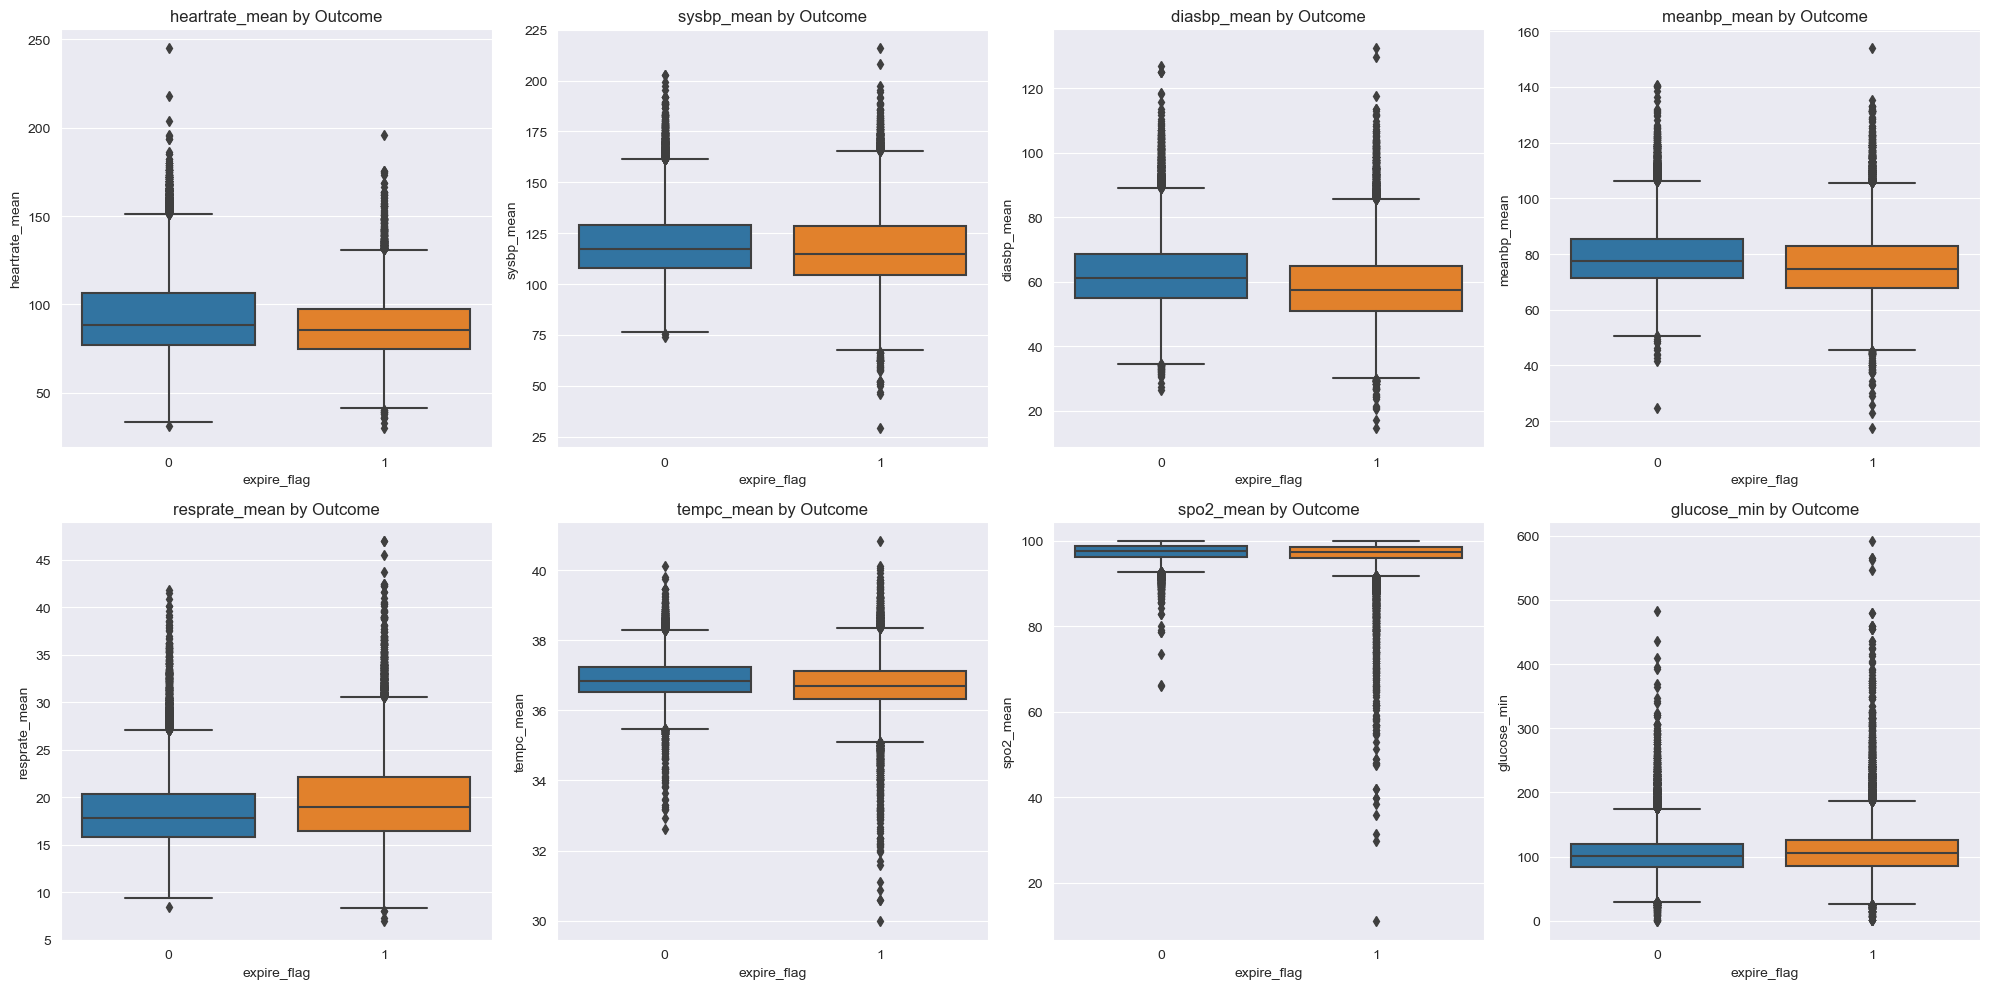

In [11]:
import seaborn as sns

vital_signs = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 'resprate_mean', 'tempc_mean',
               'spo2_mean', 'glucose_min']

n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for i, vital_sign in enumerate(vital_signs):
    row = i // n_cols
    col = i % n_cols

    sns.boxplot(x='expire_flag', y=vital_sign, data=merged_df, ax=axs[row, col])
    axs[row, col].set_title(f'{vital_sign} by Outcome')

plt.tight_layout()
plt.show()